# Learning a Probability Distribution

First, let's target a general, and very basic question: how can we learn a _probability distribution_?
If we have some knowledge about the problem at hand, we can choose a distribution, e.g. a Gaussian in the simplest case, and we have samples drawn from the target
distribution, we can train by computing a difference between the target and the parametrized distribution to be learned.

## Fundamentals: A Training Objective

A particularly simple and useful metric here is the _Kullback-Leibler (KL) divergence_ between two probability distributions ￼ $P$ and $Q$￼ with densities $p$￼ and ￼$q$.
You've surely comes across it already as it's a widely used loss term. The KL divergence is defined as
$\mathrm{KL}(p||q) = \int p(x)\, \log \left( \frac{p(x)}{q(x)} \right) dx$.

It is strictly larger than zero, $\mathrm{KL} (p||q) \geq 0$￼, and ￼has the nice property that
$\mathrm{KL}(p||q) = 0$
if and only if $P$￼ and $Q$￼ are identical.

Now let's say there is a family of densities $\{q_\theta\}_\theta$ which is parameterized by $\theta$.
It is important to stress here that all $q_\theta$ need to be a valid density. That means that $q_\theta$ is non-negative and if we integrate $q_\theta$ over the entire probability space, we obtain 1, i.e. $\int q_\theta (x) dx = 1$. Now among all these densities in our family $\{q_\theta\}_\theta$, we want to find the density parameterized by $\theta$ that is as close to $p$ as possible.
We can find such a density parameterized by $\theta$ by minimizing￼$\mathrm{KL}(p||q_\theta)$.

The training objective from the KL divergence can be rewritten as

$$
\begin{aligned}
\mathrm{KL}(p||q_\theta) &= \int p(x)\, \log \left( \frac{p(x)}{q(x)} \right) dx \\
&= \mathbb{E}_{x \sim p(x)} \left[ \log \left( \frac{p(x)}{q_\theta(x)} \right) \right] \\
&= \mathbb{E}_{x \sim p(x)} [\log p(x)] - \mathbb{E}_{x \sim p(x)}[\log q_\theta(x)].
\end{aligned}
$$

Looking at these two terms, the first one doesn't even depend on $\theta$. The training objective for $\theta$ can be simplified to minimizing the second term only
$\mathbb{E}_{x \sim p(x)}[- \log q_\theta(x)]$.
This means we can train $q_\theta(x)$ simply by sampling from $p$, and minimizing the negative log-likelihood for $q_\theta(x)$.

![Divider](https://github.com/tum-pbs/pbdl-book/blob/master/resources/divider-gen4.jpg?raw=1)

## From Unconditional to Conditional

This very simply setup is an unconditional one. That means there is no additional information or inputs available and the distribution $P$ that we want to learn is fixed.
However, in many cases we want to condition the distribution $P$ on an observation or additional input $y$. This is the case when we want to learn the posterior distribution $P|Y$ with density $p(x|y)$ depending on $y$.
Instead of working with the unconditional densities $p(x)$, we consider the conditional densities $p(x|y)$. Note that we also need to include the information $y$ in our family of proposal densities $\{ p(x|y)_\theta \}_\theta$.
In the updated objective, we include an additional expectation for sampling $y$.

$$
\mathbb{E}_{y \sim p(y)} \left[ \mathbb{E}_{x \sim p(x|y)}[- \log q_\theta(x|y)]\right] ~.
$$

With Bayes' theorem, we can directly rewrite this as

$$
\begin{aligned}
\mathbb{E}_{y \sim p(y)} \left[ \mathbb{E}_{x \sim p(x|y)}[- \log q_\theta(x|y)]\right]
&= - \int \int p(y) p(x|y) \, \log p(x|y) dx dy \\
&= - \int \int p(y, x) \, \log p(x|y) dx dy \\
&= - \int \int p(x) p(y | x) \, \log p(x|y) dy dx \\
&= \mathbb{E}_{x \sim p(x), y \sim p(y|x)} [- \log q_\theta(x|y)] ~.
\end{aligned}
$$

In simulation-based inference and scientific machine learning, $p(x)$ represents our prior and $y$ an observation.
Given a realization from the prior $x \sim p(x)$, we can sample an observation $y \sim p(y|x)$ using for example numerical simulations.
The most interesting but also difficult quantity to find for the scientist is the posterior $p(x|y)$.

The above equations tell us that we can learn the posterior $p(x|y)$ by finding an optimal $\theta$ in our family of proposal densities $\{ p(x|y)_\theta \}_\theta$.
For that, we need to minimize
$$
\mathbb{E}_{x \sim p(x), y \sim p(y|x)} [- \log q_\theta(x|y)].
$$

This only requires sampling from the prior $x$ and drawing observations $y \sim p(y|x)$. Those are two things that we know how to do them!

Hence, even for conditional probabilities like the posterior of our inverse problems, we can use an extremely simple training objective ... _if and only if_ we can make sure that $q_\theta$ is a probability density. How to enforce this is the topic of the next section. It's worth pointing out that _negative log-likelihood_ training for Gaussian densities is actually equivalent to minimizing an $L^2$ error. This is a nice conceptual connection towards earlier topics like {doc}`supervised`, but below we'd like to get away from being restricted to simple Guassian distributions.


------------------

## Learning Distributions with Normalizing Flows

Various ways to learn distributions and probabilities have been proposed in the deep learning area, and _Normalizing Flows_ are a particularly powerful one {cite}`kobyzev2020nf`.
These flows generally target transformations of a simple base distribution $p_Z$￼ into a potentially complicated target distribution ￼$p_Y$. The key idea is to use a sequence of invertible and differentiable mappings as layers for the neural network. Hence the _"normalizing"_ in the name. Here, $p_Z$ resembles the latent states from the SBI section above, but a restriction is that it needs to be a (simple) distribution we can easily sample from.

```{figure} resources/prob01-cnf.jpg
---
height: 240px
name: probmod-cnf
---
A visual example: a simple Gaussian (left) is transformed into a non-trivial target distribution (right).
```

For a single, invertible mapping $g : \mathbb{R}^D \to \mathbb{R}^D$￼ and inverse function $f=g^{-1}$￼, we have $y = g(y)$￼ and, vice versa, ￼ $z = f(y)$.
The probability density
$p_Y(y)$ can be computed as $p_Y(y) = p_Z(f(y))  \left| \mathrm{det} \tfrac{\partial f}{\partial y} \right|$.
Here
$\frac{\partial f}{\partial y}$ is the Jacobian of $f$, and the magnitude of its determinant provides the scaling of $y$ due to $f$. $P_Z$￼ is usually a normal Gaussian, so luckily evaluating $p_Z \big(f(\,y)\big)$￼ is easy.

If $p_Y$ is a function with internal parameters,
this similarly holds for the log likelihoods w.r.t. its parameters: $\log p_Y(y) = \log p_Z(f(y)) + \log \left| \mathrm{det} \tfrac{\partial f}{\partial y} \right|$.
Hence a convenient way to perform maximum likelihood training later is via a KL divergence term (unconditional or conditional) as described just above.
Note that maximizing probability densities is equivalent to maximizing likelihoods (this follows from the fundamental theorem of calculus ), and hence many works (and the following explanations) switch back and forth between them.

Of course, we're not restricted to single functions $g$ and $f$. The same holds for a sequence of mappings $g = g_1 \circ g_2 \circ \dots \circ g_n$ and $f = f_n \circ f_{n-1} \circ ... \circ f_1$, where each $g_i$ is the inverse of $f_i$. The probability density $p_Y(y)$ can still be written as $ p_Y(y) = p_Z \big(f(Z) \big) ~ \prod_{i=1}^n  \left| \mathrm{det}\frac{\partial f_i}{\partial y_i}\right|$.

Sampling is also very convenient in this settings: draw a random vector from $p_Z(z)$￼, which is usually a normal Gaussian. We obtain a sample from the target distribution via $y=g(z)$, and it's probability is computed by transforming $p_Z(z)$ into $p_Y$, as outlined above.
For $y$ we use the "forward" sequence with all the $g_i$, while the "backward" sequence $f_i$, together with its Jacobians, provides the right probability density.
This is great, and works for _unconditional_ sampling as well as _conditional_ sampling with the simple negative log likelihood objective.




上面大抵介绍了几个内容，

第一，KL散度这个目标函数，KL为0时，代表两个进行计算的概率密度完全相同。

第二，一般的，真实条件概率密度函数很难采样，这也就很难计算指定输入下的条件概率，为此，会采用提议密度，或者说近似分布的方法，使用一个可调参数的分布来近似真实条件概率密度函数。

第三，在深度学习里，一般可以选取一个简单的提议密度，然后经过多层FC（可导可微即可）来推理真实的提议密度，这类方法称为normalizing flows.

## Practical Example: Learning Gaussians

Let's use this theoretical knowledge to learn a probability distribution. First, we define a probability distribution $P$ that consists of multiple Gaussians. We want to be able to sample from this distribution and evaluate the likelihoods.


In [1]:
import numpy as np

class GaussianMixture:
    def __init__(self, parameters):

        self.parameters = parameters
        self.distributions = [
            {
                'mean': np.array(dist['mean']),
                'std': np.array(dist['std']),
                'cov': np.diag(np.array(dist['std']) ** 2)
            }
            for dist in parameters
        ]

    def sample(self, num_samples):
        samples = []
        num_distributions = len(self.distributions)
        for _ in range(num_samples):
            idx = np.random.randint(num_distributions)  # Choose a random Gaussian
            dist = self.distributions[idx]
            sample = np.random.multivariate_normal(mean=dist['mean'], cov=dist['cov'])
            samples.append(sample)
        return np.array(samples)

    def likelihood(self, points):
        likelihoods = np.zeros(points.shape[0])
        for dist in self.distributions:
            mean = dist['mean']
            cov = dist['cov']
            inv_cov = np.linalg.inv(cov)
            det_cov = np.linalg.det(cov)

            # Multivariate Gaussian PDF
            factor = 1 / (2 * np.pi * np.sqrt(det_cov))
            diff = points - mean
            exponents = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            likelihoods += factor * np.exp(exponents)

        return likelihoods


The above class `GaussianMixture` (GM) can be used to sample from multiple 2D Gaussian distributions and we can use it to evaluate the likelihood at different positions. Now, let's visualize how the samples are distributed and what the likelihood looks like. For this, we define a function for plotting first and then use it to plot a model consisting of two Gaussians with different variances and means.

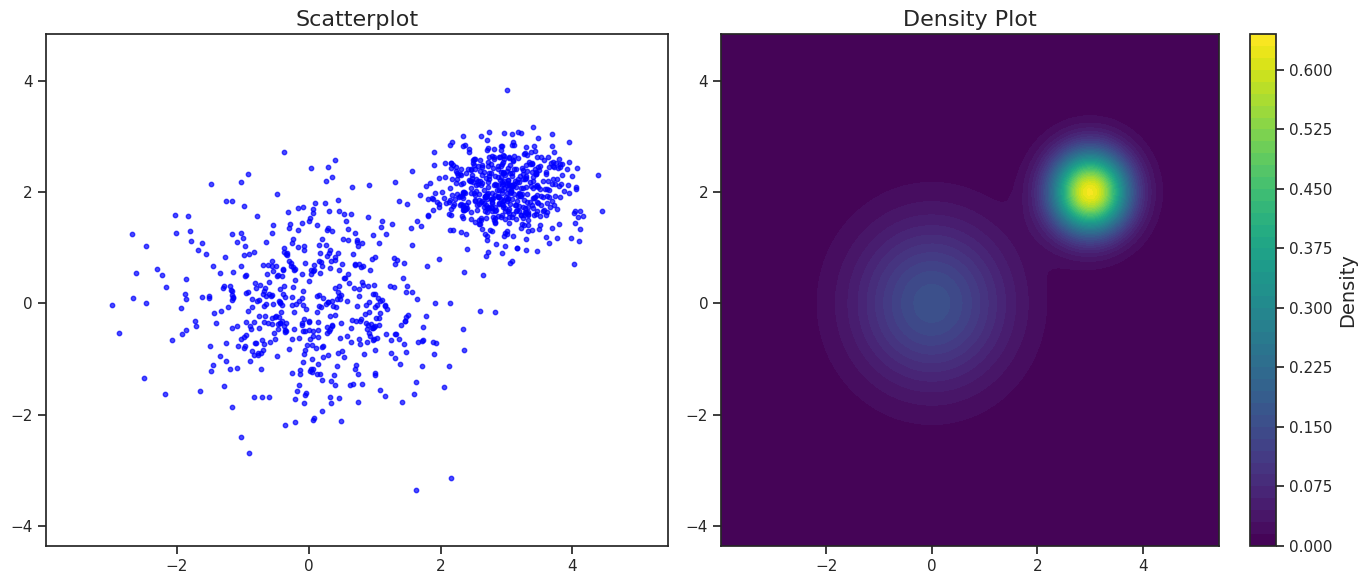

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="ticks")

def plot_gaussian_mixture(gm, samples, grid_size=100):

    x_min, x_max = np.min(samples[:, 0]) - 1, np.max(samples[:, 0]) + 1
    y_min, y_max = np.min(samples[:, 1]) - 1, np.max(samples[:, 1]) + 1
    x = np.linspace(x_min, x_max, grid_size)
    y = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])
    densities = gm.likelihood(points).reshape(grid_size, grid_size)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    ax1 = axes[0]
    ax1.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, color="blue")
    ax1.set_title("Scatterplot", fontsize=16)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)

    ax2 = axes[1]
    contour = ax2.contourf(X, Y, densities, cmap="viridis", levels=50)
    cbar = fig.colorbar(contour, ax=ax2)
    cbar.set_label("Density", fontsize=14)
    ax2.set_title("Density Plot", fontsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

parameters = [
    {"mean": [0, 0], "std": [1, 1]},
    {"mean": [3, 2], "std": [0.5, 0.5]}
]
gm = GaussianMixture(parameters)

samples = gm.sample(1000)
plot_gaussian_mixture(gm, samples)


We'll use this distribution as a starting point for the following code examples.

## A Simple Normalizing Flow based on Affine Couplings

Let's build a simple network that puts these ideas to use. We'll use a fully connected NN (`FCNN` below) with three layers and ReLU activations as a building block to turn it into an invertible layer as described above. The cell below then provides a base class `RealNVP2D`, which stands for `volume-preserving flows` in 2D. It concatenates multiple of these building blocks (6 in our example below) to form an NN that we can train to learn our toy GM distribution shown just above.

In [3]:
import torch.nn as nn

class FCNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):

        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
# 这里这个是块代码，用来构建后面的realNVP的
# 大概是在干，分解 仿射变换 拼接，这一系列变换显然是一类可逆变换
class NVPBlock2D(nn.Module):
    def __init__(self, dim_flow, hidden_dim=256, flip=False):
        super().__init__()
        self.dim_flow = dim_flow
        self.hidden_dim = hidden_dim
        self.flip = flip

        self.f = FCNN((dim_flow // 2), dim_flow, hidden_dim)

    def shift_and_log_scale_fn(self, x1):
        s = self.f(x1)
        shift, log_scale = torch.chunk(s, 2, dim=1)
        return shift, log_scale

    def forward(self, x, ldj=None):
        d = self.dim_flow // 2
        x1, x2 = x[:, :d], x[:, d:]
        if self.flip:
            x1, x2 = x2, x1

        fcnn_input = x1

        shift, log_scale = self.shift_and_log_scale_fn(fcnn_input)
        y2 = x2 * torch.exp(log_scale) + shift

        if self.flip:
            x1, y2 = y2, x1
        z = torch.cat([x1, y2], dim=-1)

        if ldj is not None:
            ldj = ldj + log_scale.sum(dim=-1)

        return z, ldj

    def inverse(self, z, ldj=None):

        d = self.dim_flow // 2
        y1, y2 = z[:, :d], z[:, d:]
        if self.flip:
            y1, y2 = y2, y1

        fcnn_input = y1

        shift, log_scale = self.shift_and_log_scale_fn(fcnn_input)
        x2 = (y2 - shift) * torch.exp(-log_scale)  # Apply inverse affine transformation

        if self.flip:
            y1, x2 = x2, y1
        x = torch.cat([y1, x2], dim=-1)

        if ldj is not None:
            ldj = ldj - log_scale.sum(dim=-1)

        return x, ldj

class RealNVP2D(nn.Module):
    def __init__(self, dim_flow, steps=6, hidden_dim=256):
        super().__init__()
        self.flows = nn.ModuleList()
        flip = False

        for _ in range(steps):
            self.flows.append(NVPBlock2D(dim_flow, hidden_dim, flip=flip))
            flip = not flip

    def forward(self, x, num_layers=None):

        if num_layers is None:
            num_layers = len(self.flows)

        ldj = torch.zeros(x.shape[0], device=x.device)
        for flow in self.flows[:num_layers]:
            x, ldj = flow(x, ldj)
        return x, ldj

    def inverse(self, z, num_layers=None):

        if num_layers is None:
            num_layers = len(self.flows)

        ldj = torch.zeros(z.shape[0], device=z.device)
        for flow in list(reversed(self.flows[:num_layers])):
            z, ldj = flow.inverse(z, ldj)
        return z, ldj

### Setup Dataset and Train the Normalizing Flow

As dataset we'll simply sample from the GM, allocate a `RealNVP2D` model, and train it for the chosen number of epochs (50 below).

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def generate_2d_gaussian_mixture(num_samples, gm):
    samples = gm.sample(num_samples)
    return torch.tensor(samples, dtype=torch.float32)

def train_model(model, dataloader, optimizer, num_epochs=50, device="cuda"):
    model.train()
    model.to(device)
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x in dataloader:
            x = x[0].to(device)
            optimizer.zero_grad()

            z, ldj = model(x)
            prior = (-0.5 * z ** 2).sum(-1) - 0.5 * torch.log(torch.tensor(2.0 * torch.pi))
            loss = (-prior - ldj).mean()

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")
    return losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.utils import shuffle

samples = generate_2d_gaussian_mixture(50000, gm)
samples = shuffle(samples.numpy())
dataset = TensorDataset(torch.tensor(samples, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

dim_flow = 2
steps = 6
hidden_dim = 256

realnvp_model = RealNVP2D(dim_flow, steps, hidden_dim).to(device)
optimizer = torch.optim.Adam(realnvp_model.parameters(), lr=2e-4)

# Step 3: Train the model
num_epochs = 50
losses = train_model(realnvp_model, dataloader, optimizer, num_epochs=num_epochs, device=device)

Epoch 1/50, Loss: 2.0702
Epoch 2/50, Loss: 1.9708
Epoch 3/50, Loss: 1.9565
Epoch 4/50, Loss: 1.9448
Epoch 5/50, Loss: 1.9404
Epoch 6/50, Loss: 1.9350
Epoch 7/50, Loss: 1.9327
Epoch 8/50, Loss: 1.9327
Epoch 9/50, Loss: 1.9292
Epoch 10/50, Loss: 1.9265
Epoch 11/50, Loss: 1.9262
Epoch 12/50, Loss: 1.9250
Epoch 13/50, Loss: 1.9241
Epoch 14/50, Loss: 1.9218
Epoch 15/50, Loss: 1.9201
Epoch 16/50, Loss: 1.9210
Epoch 17/50, Loss: 1.9194
Epoch 18/50, Loss: 1.9169
Epoch 19/50, Loss: 1.9170
Epoch 20/50, Loss: 1.9181
Epoch 21/50, Loss: 1.9128
Epoch 22/50, Loss: 1.9147
Epoch 23/50, Loss: 1.9161
Epoch 24/50, Loss: 1.9162
Epoch 25/50, Loss: 1.9118
Epoch 26/50, Loss: 1.9125
Epoch 27/50, Loss: 1.9119
Epoch 28/50, Loss: 1.9118
Epoch 29/50, Loss: 1.9098
Epoch 30/50, Loss: 1.9106
Epoch 31/50, Loss: 1.9111
Epoch 32/50, Loss: 1.9091
Epoch 33/50, Loss: 1.9110
Epoch 34/50, Loss: 1.9098
Epoch 35/50, Loss: 1.9100
Epoch 36/50, Loss: 1.9068
Epoch 37/50, Loss: 1.9085
Epoch 38/50, Loss: 1.9083
Epoch 39/50, Loss: 1.

上面是生成了一组高斯分布，然后用NVP来学习

### Visualizing the Likelihood of the Trained Normalizing Flow

A main motivation for the simple Gaussian mixture distribution as learning target is that we can easily verify learning success with visualizations. Hence, the cell below plots samples from the original and the learned distribution to qualitatively verify that the normalizing flow model has learned to approximate the target distribution. Also, we can now visualize the likelihoods by sampling the distributions in a dense grid. The corresponding images are shown on the right.

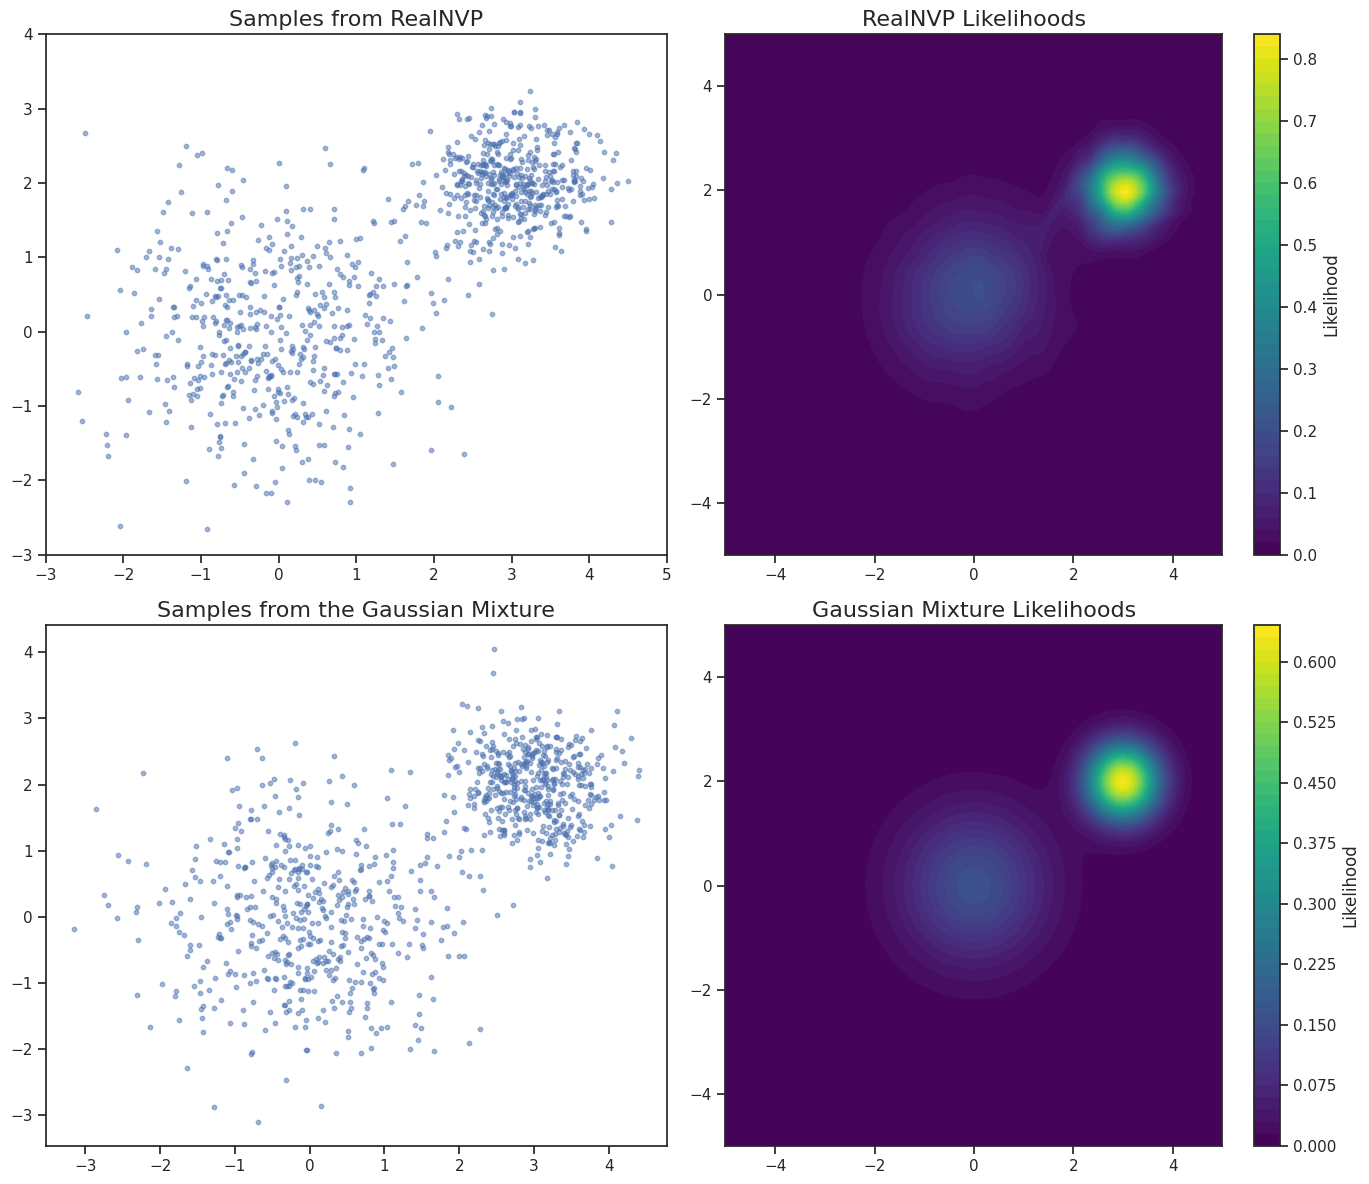

In [5]:
def visualize_training_results(model, gm, grid_size=100, dim=2, model_desc='Model'):

    model.eval()
    with torch.no_grad():
        z = torch.randn(1000, dim).to(device)
        samples, _ = model.inverse(z)

    samples = samples.cpu().numpy()
    gm_samples = gm.sample(1000)

    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])

    with torch.no_grad():

        points_tensor = torch.tensor(points, device=device, dtype=torch.float32)
        z, ldj = model(points_tensor)
        prior = (-0.5 * z ** 2).sum(-1) - 0.5 * torch.log(torch.tensor(2.0 * torch.pi))
        model_likelihoods = torch.exp(prior + ldj).cpu().numpy().reshape(grid_size, grid_size)

        gm_likelihoods = gm.likelihood(points).reshape(grid_size, grid_size)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    axes[0, 0].scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.5, label="")
    axes[0, 0].set_title(f"Samples from {model_desc}", fontsize=16)
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_ylabel('')

    contour = axes[0, 1].contourf(X, Y, model_likelihoods, levels=50, cmap="viridis")
    fig.colorbar(contour, ax=axes[0, 1], label="Likelihood")
    axes[0, 1].set_title(f"{model_desc} Likelihoods", fontsize=16)
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('')

    axes[1, 0].scatter(gm_samples[:, 0], gm_samples[:, 1], s=10, alpha=0.5, label="")
    axes[1, 0].set_title("Samples from the Gaussian Mixture", fontsize=16)
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_ylabel('')

    contour = axes[1, 1].contourf(X, Y, gm_likelihoods, levels=50, cmap="viridis")
    fig.colorbar(contour, ax=axes[1, 1], label="Likelihood")
    axes[1, 1].set_title("Gaussian Mixture Likelihoods", fontsize=16)
    axes[1, 1].set_xlabel('')
    axes[1, 1].set_ylabel('')

    for i in range(1):
        for j in range(1):
            axes[i, j].set_xlim([-3,5])
            axes[i, j].set_ylim([-3,4])

    plt.tight_layout()
    plt.show()

visualize_training_results(realnvp_model, gm, model_desc='RealNVP')

As expected, our network has learned likelihoods that nicely approximate the reference likelihoods.

### Visualizing Different Layers

The invertible NVP network consisted of six layers, that step by step transform the prior distribution into the posterior. As the mapping of each layer is density-mass preserving, we can inspect what happens step by step. This is shown via the cell below:

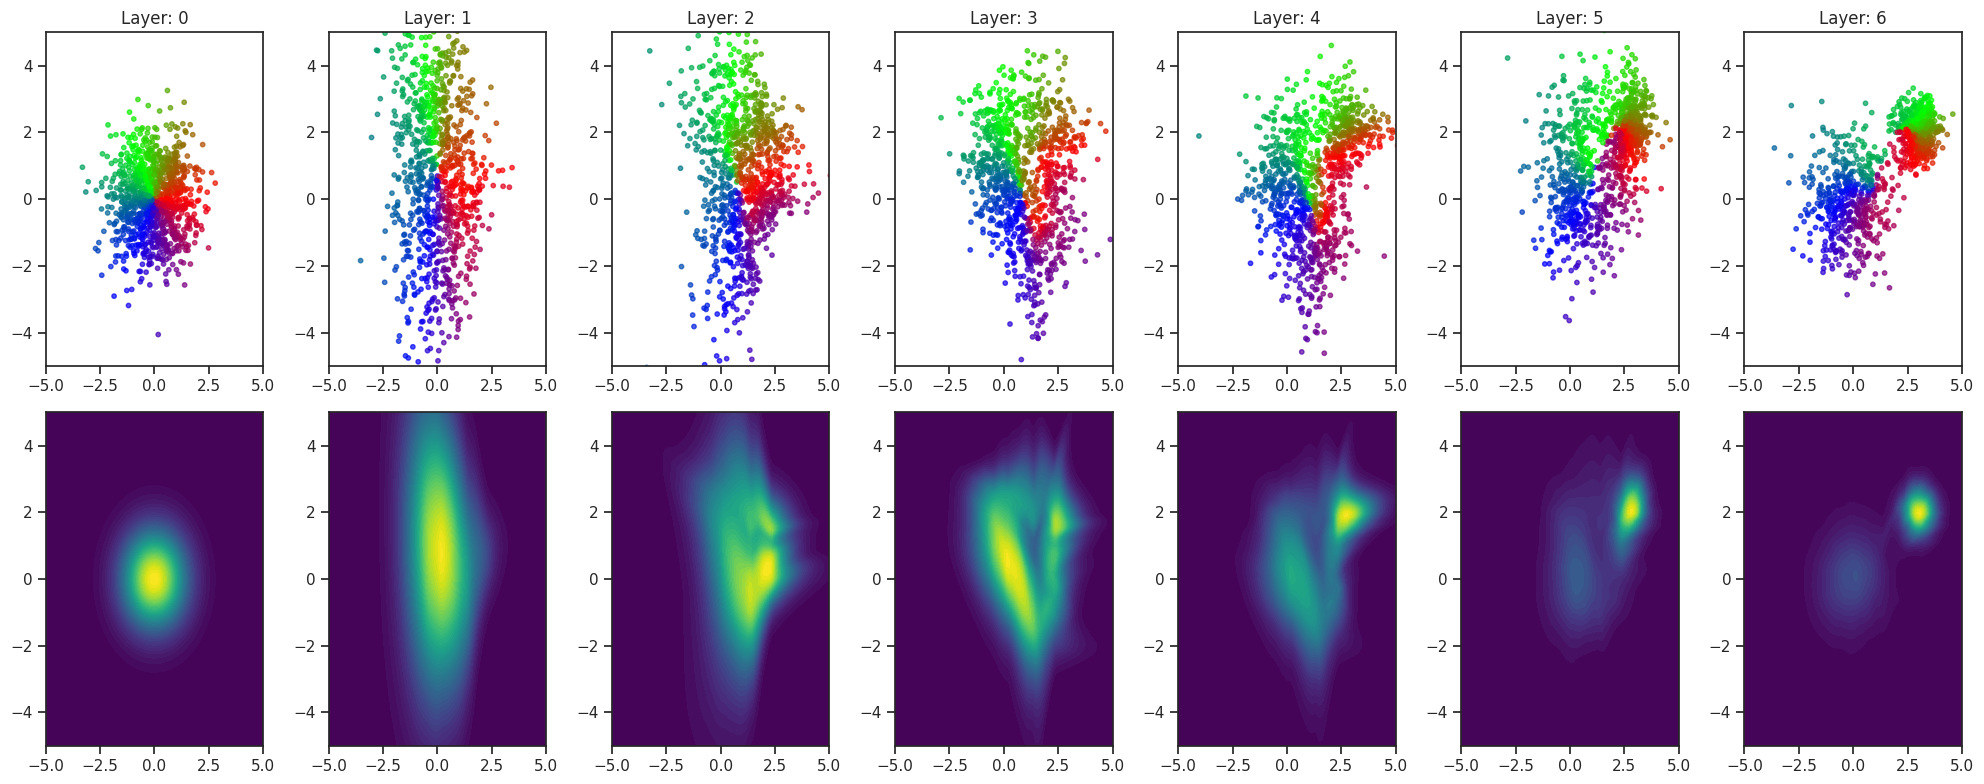

In [6]:
import matplotlib.pyplot as plt

def get_angle_colors(positions):
    angles = np.arctan2(positions[:, 1], positions[:, 0])
    angles_deg = (np.degrees(angles) + 360) % 360
    colors = np.zeros((len(positions), 3))
    for i, angle in enumerate(angles_deg):
        segment = int(angle / 120)
        local_angle = angle - segment * 120  # angle within segment [0, 120]
        if segment == 0:
            colors[i] = [1 - local_angle/120, local_angle/120, 0]
        elif segment == 1:
            colors[i] = [0, 1 - local_angle/120, local_angle/120]
        else:
            colors[i] = [local_angle/120, 0, 1 - local_angle/120]

    return colors

def visualize_progression_with_layers_and_likelihoods(model, grid_size=100, num_layers_max=6, num_samples=1000):

    model.eval()
    fig, axes = plt.subplots(2, num_layers_max + 1, figsize=(20, 8))

    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])
    points_tensor = torch.tensor(points, dtype=torch.float32).to(device)

    for num_layers in range(num_layers_max + 1):

        z = torch.randn(num_samples, model.flows[0].dim_flow).to(device)

        c = get_angle_colors(z.detach().cpu().numpy())

        with torch.no_grad():
            samples, _ = model.inverse(z, num_layers=num_layers)

        samples = samples.cpu().numpy()

        scatter_ax = axes[0, num_layers]
        scatter_ax.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, c=c)
        scatter_ax.set_title(f"Layer: {num_layers}")
        scatter_ax.set_xlim(-5, 5)
        scatter_ax.set_ylim(-5, 5)
        scatter_ax.set_xlabel("")
        scatter_ax.set_ylabel("")

        with torch.no_grad():
            z, ldj = model(points_tensor, num_layers=num_layers)
            prior = (-0.5 * z ** 2).sum(-1) - 0.5 * torch.log(torch.tensor(2.0 * torch.pi))
            likelihoods = torch.exp(prior + ldj).cpu().numpy().reshape(grid_size, grid_size)

        likelihood_ax = axes[1, num_layers]
        contour = likelihood_ax.contourf(X, Y, likelihoods, levels=50, cmap="viridis")

        likelihood_ax.set_xlim(-5, 5)
        likelihood_ax.set_ylim(-5, 5)
        likelihood_ax.set_xlabel("")
        likelihood_ax.set_ylabel("")

    plt.tight_layout()
    plt.show()

visualize_progression_with_layers_and_likelihoods(realnvp_model, grid_size=100, num_layers_max=6, num_samples=1000)


Interestingly, the network does not take a very intuitive "route" to reach the target: the prior distribution is warped in somewhat arbitrary ways, which however, step by step move closer to the target distribution. As there are no constraints on the intermediate distributions, these strongly depend on the random initialization, and the network only receives no gradients about the final distribution. Hence, the intermediates can retain their arbitrary shapes as long as the final state matches.

每个NVPBlock其实输出都是概率分布，所以可以看到，上面这个过程和Diffusion有点像的。

## Neural ODEs: Making Normalizing Flows Continuous

In the Normalizing Flow based on affine coupling layers that we had considered in the previous section, there are a total of 6 layers and we could observe how the initial Gaussian distribution is transformed step-by-step to the target distribution.

**A big limitation of this type of normalizing flow is that the architecture needs to be invertible. Most efficient architectures in deep learning are not invertible.**

Our next goal is to get rid of this limitation so that we can use an arbitrary architecture. At the same time, this will address another shortcoming. Right now, the number of layers is fixed. Is it possible that instead of using a fixed number of layers, we can make the number of layers variable? If we imagine the transformation of the sampling distribution to the target distribution to be a continuous process instead of a sequence of invertible mappings, we can introduce an artificial "time" $t$. Our normalizing flow should transform the sampling distribution smoothly from time $t=0$ to the target distribution at time $t=1$.

The way in which we can achieve this are _Neural ODEs_{cite}`chen2019node`.
They're especially interesting in the context of physics simulations. Mathematically speaking, they replace the mapping $g_i$ with a learned velocity predictor $g_\theta$. This means

$$
\frac{\partial z(t)}{\partial t} = g_\theta(z(t), t).
$$

Then the sequence of $g_i$ steps that made up $g$  can be replaced by integrating the velocity, which gives a simple ODE integration.
The continuous time axis is introduced, with $t=0$ starting at a normal Gaussian distribution, to $t=1$ for the target distribution.
The ODE is solved along this timeline, e.g. to transform the base distribution $p_Z$ into the target $p_Y$ by querying $g$ for a velocity at each time point along the way.
Even better, for an ODE solve there's an analytic formulation for the gradient of the backpropagation path. This is a neat example of a differentiable physics solver (the ODE solve), providing an efficient way to compute a gradient, and aligns with the topics discussed in {doc}`physgrad`.

The change in probabilities over time can also be computed conveniently via the trace of the learned function:

$$
\frac{\partial \log p(z(t))}{\partial t} = - \mathrm{Tr} \left( \frac{\partial g_\theta}{\partial z(t)} \right).
$$

Compared to the Normalizing Flows above, an important difference in the NeuralODE picture is that now we have a single function $g_\theta(\cdot,t)$ that is repeatedly evaluated at different points in the time interval $t \in [0,1]$. This might seem like a trivial change at first, but it's a crucial step towards more powerful probabilistic models such as diffusion models.
It turns out to be important that we can re-use a learned function, instead of having to manually construct many layers with large numbers of trainable parameters.

### Building a Continuous Normalizing Flow

In the next cell's we'll use the _Free-form Jacobian of Reversible Dynamics_ (FFJORD) architecture [(from here)](https://arxiv.org/abs/1810.01367) to implement a continuous normalizing flow.


神经ODE可以用ODE的一些方法来计算梯度，因而避免了手动设计多层可逆变换的限制。

时间演化的概念则替换了层的概念，使得ODE可以在ini_T 到 end_T这个区间上连续评估，而非多个离散层进行评估，这样使得整个转换更加光滑。


In [7]:
import torch.nn as nn

def kernel_init_fn():
    return nn.init.xavier_uniform_

def bias_init_fn():
    return nn.init.zeros_

class ConcatSquash(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.out_size = out_size

        self.lin1 = nn.Linear(in_size, out_size)
        self.lin2 = nn.Linear(1, out_size)
        self.lin3 = nn.Linear(1, out_size, bias=False)

        kernel_init = kernel_init_fn()
        kernel_init(self.lin1.weight)
        kernel_init(self.lin2.weight)
        kernel_init(self.lin3.weight)

        bias_init = bias_init_fn()
        bias_init(self.lin1.bias)
        bias_init(self.lin2.bias)

    def forward(self, t, y):
        if t.dim() == 0:
            t = t.view(1, 1)
        elif t.dim() == 1:
            t = t.view(-1, 1)

        return self.lin1(y) * torch.sigmoid(self.lin2(t)) + self.lin3(t)

class FFJORD(nn.Module):
    def __init__(self, data_size, width_size, depth):
        super().__init__()
        self.data_size = data_size
        self.width_size = width_size
        self.depth = depth

        layers = []

        if self.depth == 0:
            layers.append(ConcatSquash(in_size=data_size, out_size=self.data_size))
        else:
            layers.append(ConcatSquash(in_size=data_size, out_size=self.width_size))
            for _ in range(self.depth - 1):
                layers.append(ConcatSquash(in_size=width_size, out_size=self.width_size))
            layers.append(ConcatSquash(in_size=width_size, out_size=self.data_size))

        self.layers = nn.ModuleList(layers)

    def forward(self, t, y):
        for layer in self.layers[:-1]:
            y = layer(t, y)
            y = torch.tanh(y)
        y = self.layers[-1](t, y)
        return y

### The Continuous Normalizing Flow Network

For ODE integration, we'll make use of the differentiable ODE solvers from the `torchdiffeq` package.

In [8]:
try:
    import google.colab  # only to ensure that we are inside colab
    %pip install --quiet torchdiffeq
except ImportError:
    print("This notebook is running locally, please install torchdiffeq manually.")

The `ContinuousNormalizingFlow` class implements the basic functionality to integrate the neural velocity estimator via `odeint` in a differentiable manner. The latter is important to allow for backpropagating the gradients from the loss (and the output of the integration step) back to the weights of the FFJORD network.

In [9]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

class CNFVelocityFn(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers=8):
        super().__init__()

        self.net = FFJORD(data_size=input_dim, width_size=hidden_dim, depth=num_layers)

    def forward(self, t, combined_state):
        y, ldj = combined_state

        with torch.set_grad_enabled(True):
            y.requires_grad_(True)
            t.requires_grad_(True)

            t = torch.unsqueeze(t.repeat(y.shape[0]), 1)

            velocity = self.net(t, y)

            divergence = 0.0
            for i in range(y.shape[1]):
                divergence += torch.autograd.grad(velocity[:, i].sum(), y, create_graph=True)[0][:, i]

        return velocity, divergence.view(velocity.shape[0], 1)

class ContinuousNormalizingFlow(nn.Module):

    def __init__(self, input_dim, hidden_dim,
                 time_0=0.0, time_T=1.0):

        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.time_0 = time_0
        self.time_T = time_T

        self.velocity_fn = CNFVelocityFn(input_dim=input_dim, hidden_dim=hidden_dim)

    def solveODE(self, x, t):

        batch_size, dim = x.shape
        assert dim == self.input_dim, "Input dimension mismatch!"

        y0 = x
        ldj0 = torch.zeros(batch_size, device=x.device)

        combined_state = (y0, ldj0)

        result = odeint(self.velocity_fn, combined_state, t,
                        method='dopri5',
			            atol=[1e-5, 1e-5],
			            rtol=[1e-5, 1e-5],
                        )

        final_y, final_ldj = result

        return final_y[-1], final_ldj[-1]

    def forward(self, x):

        t = torch.tensor([self.time_0, self.time_T], device=x.device)

        return self.solveODE(x, t)

    def inverse(self, x):

        t = torch.tensor([self.time_T, self.time_0], device=x.device)

        return self.solveODE(x, t)

### Training

The training step can re-use the `train_model` function from above, as all basic modalities (data format, loss, etc.) stay the same. We're only replacing the "discrete" step-by-step transformation with the continuously integrated version.

In [10]:
samples = generate_2d_gaussian_mixture(5000, gm) # use fewer samples because training takes longer
samples = shuffle(samples.numpy())
dataset = TensorDataset(torch.tensor(samples, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

input_dim = 2
hidden_dim = 128
time_0 = 0.0
time_T = 1.0

cnf_model = ContinuousNormalizingFlow(input_dim=input_dim, hidden_dim=hidden_dim, time_0=time_0, time_T=time_T)

learning_rate = 2e-4
optimizer = torch.optim.Adam(cnf_model.parameters(), lr=learning_rate)

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
losses = train_model(cnf_model, dataloader, optimizer, num_epochs=num_epochs, device=device)

Epoch 1/50, Loss: 3.9587
Epoch 2/50, Loss: 2.6360
Epoch 3/50, Loss: 2.3546
Epoch 4/50, Loss: 2.3349
Epoch 5/50, Loss: 2.3115
Epoch 6/50, Loss: 2.2993
Epoch 7/50, Loss: 2.3081
Epoch 8/50, Loss: 2.2744
Epoch 9/50, Loss: 2.2533
Epoch 10/50, Loss: 2.2193
Epoch 11/50, Loss: 2.1857
Epoch 12/50, Loss: 2.1837
Epoch 13/50, Loss: 2.1518
Epoch 14/50, Loss: 2.1454
Epoch 15/50, Loss: 2.1154
Epoch 16/50, Loss: 2.1111
Epoch 17/50, Loss: 2.0822
Epoch 18/50, Loss: 2.0695
Epoch 19/50, Loss: 2.0395
Epoch 20/50, Loss: 2.0440
Epoch 21/50, Loss: 1.9956
Epoch 22/50, Loss: 2.0005
Epoch 23/50, Loss: 2.0024
Epoch 24/50, Loss: 1.9826
Epoch 25/50, Loss: 1.9670
Epoch 26/50, Loss: 1.9928
Epoch 27/50, Loss: 1.9592
Epoch 28/50, Loss: 1.9686
Epoch 29/50, Loss: 1.9405
Epoch 30/50, Loss: 1.9541
Epoch 31/50, Loss: 1.9550
Epoch 32/50, Loss: 1.9411
Epoch 33/50, Loss: 1.9432
Epoch 34/50, Loss: 1.9383
Epoch 35/50, Loss: 1.9347
Epoch 36/50, Loss: 1.9461
Epoch 37/50, Loss: 1.9432
Epoch 38/50, Loss: 1.9371
Epoch 39/50, Loss: 1.

### Visualization of the Continuous Normalizing Flow

Now we can repeat the same steps as before to visualize what this second network has learned.

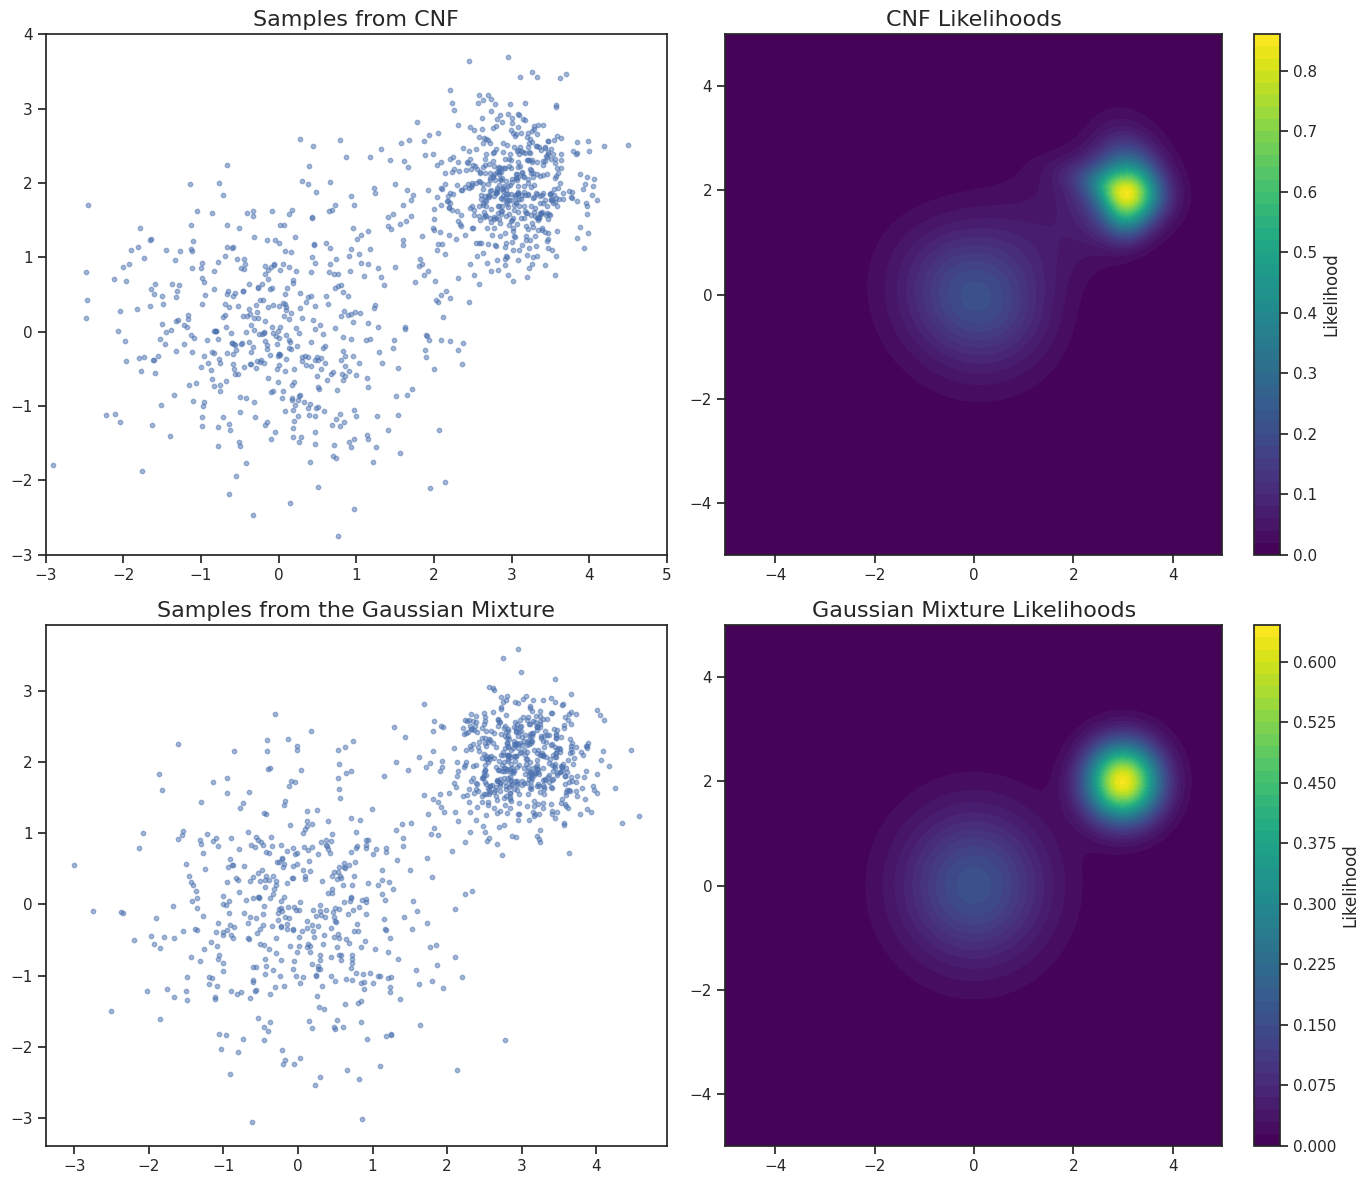

In [12]:
visualize_training_results(cnf_model.to(device), gm, 100, model_desc='CNF')

This looks good, how does the continuous version treat the intermediate distributions? This will be visualized below.


In [11]:
def visualize_progression_with_time_and_likelihoods(model, grid_size=100, num_timepoints=6, num_samples=1000):
    model.eval()

    timepoints = torch.linspace(0.0, 1.0, num_timepoints)
    fig, axes = plt.subplots(2, num_timepoints, figsize=(20, 8))

    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])
    points_tensor = torch.tensor(points, dtype=torch.float32).to(device)

    z = torch.randn(num_samples, 2).to(device)

    c = get_angle_colors(z.cpu().numpy())

    eps = 1e-5

    for i, t in enumerate(timepoints):
        t_tensor = torch.tensor([0.0, t+eps]).to(device)
        t_tensor_inv = torch.tensor([1.0, 1.0-t-eps]).to(device)

        with torch.no_grad():

            samples, _ = model.solveODE(z, t_tensor_inv)
            samples = samples.cpu().numpy()

            z_t, ldj = model.solveODE(points_tensor, t_tensor)

            prior = (-0.5 * z_t ** 2).sum(-1) - 0.5 * torch.log(torch.tensor(2.0 * torch.pi))

            likelihoods = torch.exp(prior + ldj).cpu().numpy().reshape(grid_size, grid_size)

        scatter_ax = axes[0, i]
        scatter_ax.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, c=c)
        scatter_ax.set_title(f"t = {t:.1f}")
        scatter_ax.set_xlim(-5, 5)
        scatter_ax.set_ylim(-5, 5)
        scatter_ax.set_xlabel("X" if i == 0 else "")
        scatter_ax.set_ylabel("Y" if i == 0 else "")

        likelihood_ax = axes[1, i]
        contour = likelihood_ax.contourf(X, Y, likelihoods, levels=50, cmap="viridis")
        likelihood_ax.set_xlim(-5, 5)
        likelihood_ax.set_ylim(-5, 5)
        likelihood_ax.set_xlabel("X")
        likelihood_ax.set_ylabel("Y" if i == 0 else "")

    plt.tight_layout()
    plt.show()

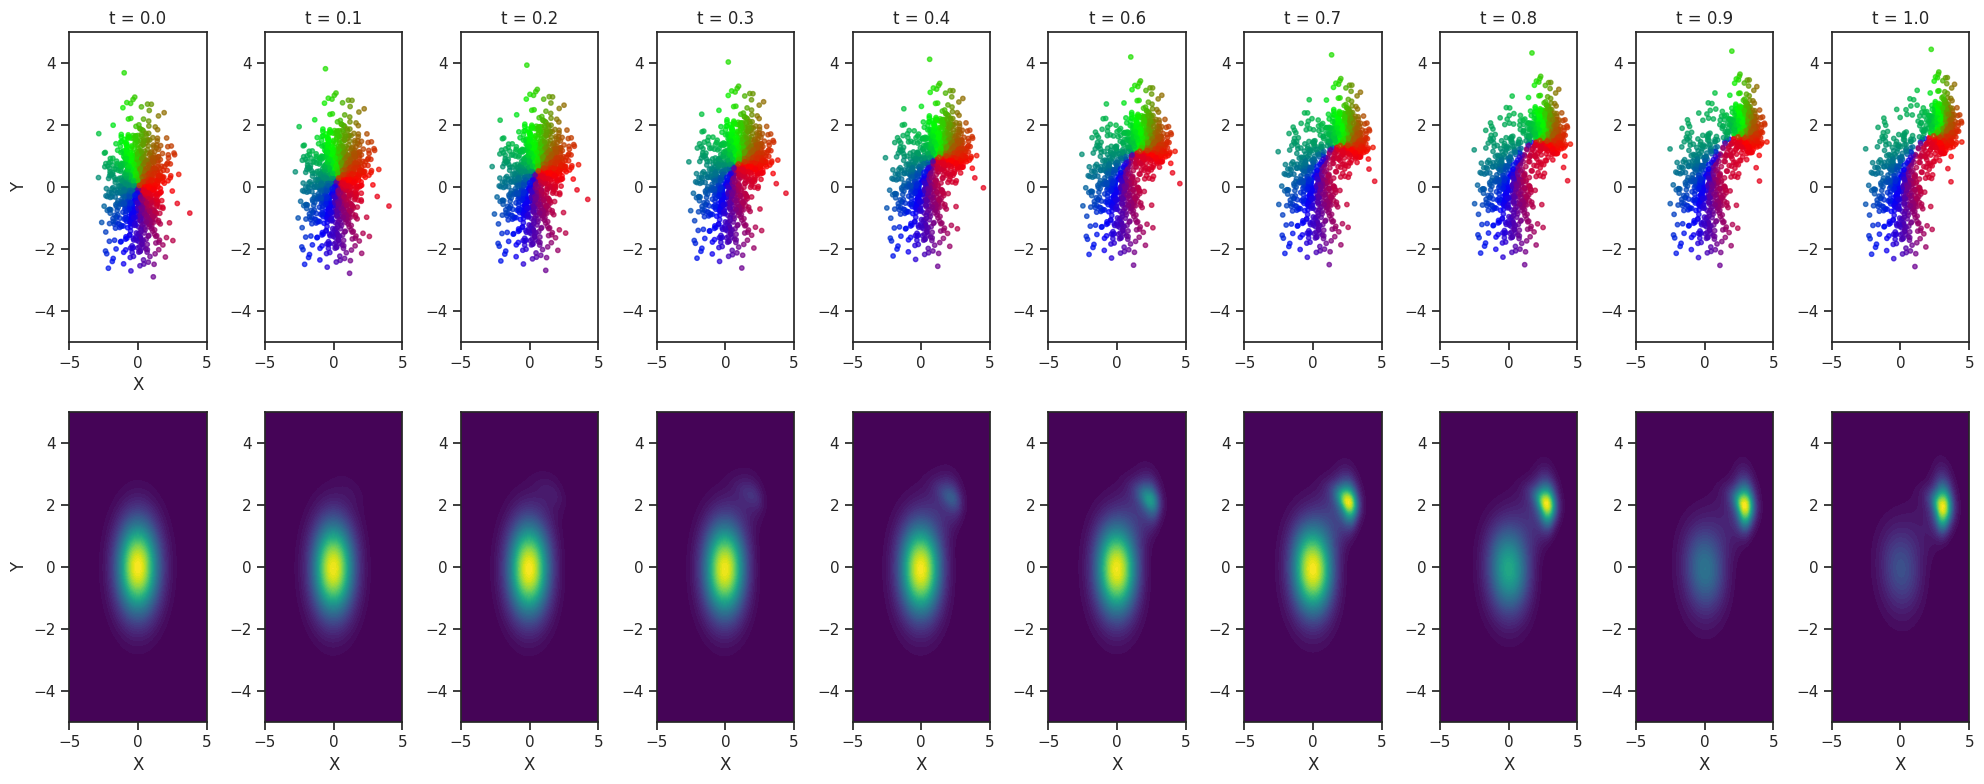

In [13]:
visualize_progression_with_time_and_likelihoods(
    cnf_model,
    grid_size=100,
    num_timepoints=10,
    num_samples=1000
)

The figure shows how the Gaussian sampling distribution is transformed to the target distribution much more smoothly using the continuous-time normalizing flow than the implementation with discrete layers.

## Summary of Normalizing Flows

This is a great result. Using our knowledge about ODE solving, we can choose basically any neural network architecture for the velocity. We can trade off speed against accuracy when solving the ODE by choosing different solvers and step sizes depending on our current computational budget.

However, there are also disadvantages with this approach. In order to train our continuous normalizing flow, we need to solve the entire ODE transporting the samples from our target distribution from $t=1$ until $t=0$ to the Gaussian distribution to evaluate their likelihoods with high accuracy. This requires a large number of network evaluations and is computationally expensive. As such, it is difficult to scale neural ODEs to high dimensional data and large neural networks.

The focus of the next section will be on more scalable methods that can be combined with very large networks and high-dimensional data.
